<a href="https://colab.research.google.com/github/667029/KVP10k/blob/main/LayoutLMv3_KVP10k_GG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dokumentforståelse med LayoutLMv3 på KVP10k-datasettet

Denne notebooken demonstrerer hvordan vi henter inn en preprossessert og tilpasset versjon av KVP10k-datasettet i Hugging Face-format, til å utføre **Key-Value Pair Extraction (KVP)** på  dokumentbilder.

- Datasettet består av over 10k forretningsdokumenter, og inneholder blant annet dokumentbilder og tilhørende nøkkel-verdi-par, som brukes av denne fine-tuned modellen som utvikles her.

- Sluttmålet er å utvikle og trene en ny modell til dokumentforståelse, ved å forstå **visuell layout**, **tekstlig innhold**, og **relasjoner mellom nøkler og verdier** i dokumentene.
  - KVP-Extraction modellen som utvikles i denne notebooken er tenkt å brukes grunnmur i sluttmodellen, for å med stor sannsynlighet beherske å linke mellom nøkkel-verdi-par i ulike dokumenter.

LayoutLMv3 er en multi-modal modell designet for å kombinere tekst, layout og annen bilde-informasjon

---

###**Notbooken dekker følgende steg**:

1. Installasjon av de nødendige biblioteker
2. Lasting av forhåndsprosessert datasett
3. Tokenisering av tekst og input-formatering med Layout sin Processor
- 3.1 Logikk for å anngi predikerte BIO-labels til dokumentets bbox'es
4. Trening av modell for token-klassifisering
5. Evaluering og lagring av modell i Drive
6. Visualisering av modell under inferense

---

###**LayoutLMv3Processor - gjør følgende**:
1. Tekst-tokenisering: Tekst fra dokumentet tokeniseres.
2. Token-connection: Hvert token kobles til en bounding box (bbox) på dokumentet, gjennom *boxes*-parmeteret som inneholder (x0,y0,x1,y1)-kordinater til hvert token.
3. Image-embedding: Dokumentbildet skaleres og legges og blir input til modellen
4. Label-alignment: Hvert token får en BIO-label, som brukes under modellens token-klassifisering

Tokeniseringen handler om å forvandle dokumentet til tokens med alle nødvendige modaliteter (tekst, layout og bilde) slik at modellen lærer sammenhengen mellom dem gjennom trening.

**Det brukes BIO-tagger, og dette er hva det står for:**
 - B --> Begin: første token i en entitet.
 - I --> Inside: inne i en entitet.
 - O --> Outside: tokenen er ikke en del av noen entitet

f.eks.
  - Tokens:  ["Name", "of", "buyer", ":", "Ole", "Martin", "Lystadmoen"]
  - Labels:  ["B-KEY", "I-KEY", "I-KEY", "O", "B-VALUE", "I-VALUE", "I-VALUE"]

# Dataset - forståelse

**Innhold i train/-mappen i KVP10k:**
_____
  - *images*/ --> .png bilder av hvert dokument. Visuell input for modellen.
    - Det modellen "ser".
_____

  - *ocrs*/ --> JSON-filer med **words** og **bboxes** for hvert dokument. Gir tekst og posisjoner fra OCR, og brukes sammen med images.
    - Det modellen "leser" (tokens og posisjonene deres).

_____

  - *gts*/ --> JSON-filer med KVPs og tilhørende bboxes. Inneholder hvilke keys og values som hører sammen.
    - Det som lærer modellen hvilke tokens som er nøkler, verdier, og hvilket som er koblet sammen.
_____

  - *items*/ --> JSON-filer med annotasjoner og layout-objs (rektangler, linker, etiketter)
    - tilleggsinformasjon
    - ikke viktig i for EE
    - Helt nødvendig i RE-delen av dette prosjektet
_____

In [1]:
#transformers: Hugging Face bibliotek som gir tilgang til LayoutLMv3
#datasets: For håndtering av dataset i Huggig Face-format
#seqeval: evalueringsbibliotek for sekvensmerking, brukes for måle metrikker for i dette tilfelle BIO-tagging
!pip install -q transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 require

In [2]:
#Håndterer ulike metrikker inkl. integrasjon med seqeval
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


In [3]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer
from transformers import LayoutLMv3Processor
import torch           #modellens input-format for data
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/kvp10k/"
print(os.listdir(base_path))

['train', 'test']


In [6]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False) # <-- Viktig fordi vi allerede har utført OCR på bildet og har tekst og bboxes

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [7]:
# Mapping fra tekstlige BIO-labels til tall som modellen bruker
label_map = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

# Funksjon for å skalere bounding boxes til 0-1000 (som LayoutLMv3 krever)
def normalize_bbox(bbox, width, height):
  return [
      int(1000 * (bbox[0] /width)),
      int(1000 * (bbox[1] / height)),
      int(1000 * (bbox[2] / width)),
      int(1000 * (bbox[3] / height))
  ]


def assign_label_for_box(box, boxes, label_type):
  """Returnerer liste med (index, label) for tokens som overlapper box"""
  overlaps = []
  for i, token_box in enumerate(boxes):
    if box_overlap(box, token_box) > 0:
      overlaps.append(i)

  overlaps = sorted(overlaps)

  labeled = []
  for j, idx in enumerate(overlaps):
    tag = f"B-{label_type}" if j == 0 else f"I-{label_type}"
    labeled.append((idx, tag))

  return labeled


#Sjekker om OCR-boksen overlapper med GTS(key/value)-boksen.
#Ved overlapp hører de til hverandre.
def box_overlap(box1, box2):
  x0 = max(box1[0], box2[0])
  y0 = max(box1[1], box2[1])
  x1 = min(box1[2], box2[2])
  y1 = min(box1[3], box2[3])
  return max(0, x1 - x0) * max(0, y1 - y0)


# Funksjon for å generere BIO-labels fra gts (ground truth).
# Lager en BIO-label for hvert token basert på om det overlapper med en key- eller value-boks fra GTS.
# Matcher hvert token fra OCR (word + bbox) mot key/value-bbokser fra gts:
# --> Token overlapper en nøkkelboks: B-KEY eller I-KEY
# --> Token overlapper en verdiboks: B-VALUE eller I-VALUE
# --> Ellers: O
def iob_from_kvps(words, boxes, kvps):
  labels = ["O"] * len(words)

  #Gå igjennom alle key-value-pairs
  for kvp in kvps:
    if "key" in kvp and "bbox" in kvp["key"]:
      key_bbox = kvp["key"]["bbox"]
      for idx, tag in assign_label_for_box(key_bbox, boxes, "KEY"):
        labels[idx] = tag

    if "value" in kvp and "bbox" in kvp["value"]:
      value_box = kvp["value"]["bbox"]
      for idx, tag in assign_label_for_box(value_box, boxes, "VALUE"):
        labels[idx] = tag

  return labels

In [8]:
!ls -lh /content/drive/MyDrive/KVP10k_processed_ready


total 8.0K
drwx------ 2 root root 4.0K Apr 10 13:12 dataset_all_gts
drwx------ 2 root root 4.0K Apr 10 08:38 datasett_3k


#Innlasting av et allerede pre-prossesert KVP10k-dataset spesielt utviklet for LayoutLMv3 (KVP-extraction).
##Ikke kjør denne!

NB: Dette prosessen gjøres i en annen notebook, vi henter inn resultatet her for å spare notebooken for plass og ryddighet.

Datasettet som lastes inn er på omlag 8600 dokumenter da det er antall dokumenter med ground-truths (gts).

In [ ]:
from google.colab import drive
from datasets import load_from_disk

# Monter Drive (hvis du ikke har gjort det)
drive.mount("/content/drive", force_remount=True)

# Last inn dataset fra riktig path
dataset = load_from_disk("/content/drive/MyDrive/KVP10k_processed_ready/dataset_all_gts")

# Hent splits
train_dataset = dataset["train"]
eval_dataset = dataset["eval"]
test_dataset = dataset["test"]

# (Valgfritt) Gjør klar for huggingface Trainer
train_dataset.set_format("torch")
eval_dataset.set_format("torch")
test_dataset.set_format("torch")

# Sjekk at alt fungerer
print("✅ Datasett lastet inn!")
print("Train:", len(train_dataset))
print("Eval:", len(eval_dataset))
print("Test:", len(test_dataset))
print("Keys:", train_dataset[0].keys())

Mounted at /content/drive
✅ Datasett lastet inn!
Train: 6273
Eval: 1569
Test: 828
Keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'])


In [ ]:
train_dataset.features

{'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
processor.tokenizer.decode(train_dataset[0]["input_ids"])

'<s> Date Net Zone/Syscode Time Spot Name Len Line Rate Flag 10-722 HIST L Middlesx Smrst Cty Zone 1302/1302 4:44PM CLFTVNJO702H 30 48 $73.00 10-722 HIST L Middlesx Smrst Cty Zone 1302/1302 7:45PM CLFTVNJO702H 30 487 $90.00 10-722 HIST L Middlesx Smrst Cty Zone 1302/1302 11:46PM CLFTVNJO702H 30 487 $90.00 10-722 AEN Morris County Zone 1305/1305 2:13PM CLFTVNJO702H 30 488 $21.00 10-722 AEN Morris County Zone 1305/1305 5:40PM CLFTVNJO702H 30 489 $49.00 10-722 AEN Morris County Zone 1305/1305 7:44PM CLFTVNJO702H 30 490 $59.00 10-722 AEN Morris County Zone 1305/1305 10:48PM CLFTVNJO702H 30 490 $59.00 10-722 CNN Morris County Zone 1305/1305 8:29AM CLFTVNJO702H 30 491 $73.00 10-722 CNN Morris County Zone 1305/1305 3:30PM CLFTVNJO702H 30 492 $65.00 10-722 CNN Morris County Zone 1305/1305 4:26PM CLFTVNJO702H 30 493 $121.00 10-722 CNN Morris County Zone 1305/1305 9:27PM CLFTVNJO702H 30 494 $164.00 10-722 DISC Morris County Zone 1305/1305 9:25AM CLFTVNJO702H 30 495 $21.00 10-722 DISC Morris Coun

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 Date 0
 Net 0
 Zone 0
/ -100
Sys -100
code -100
 Time 0
 Spot 0
 Name 0
 Len 0
 Line 0
 Rate 0
 Flag 0
 10 0
- -100
7 -100
22 -100
 H 0
IST -100
 L 0
 Middles 0
x -100
 Sm 0
r -100
st -100
 C 0
ty -100
 Zone 0
 130 0
2 -100
/ -100
130 -100
2 -100
 4 0
: -100
44 -100
PM -100
 CL 0
F -100
TV -100
NJ -100
O -100
702 -100
H -100
 30 0
 48 0
 $ 0
73 -100
. -100
00 -100
 10 0
- -100
7 -100
22 -100
 H 0
IST -100
 L 0
 Middles 0
x -100
 Sm 0
r -100
st -100
 C 0
ty -100
 Zone 0
 130 0
2 -100
/ -100
130 -100
2 -100
 7 0
: -100
45 -100
PM -100
 CL 0
F -100
TV -100
NJ -100
O -100
702 -100
H -100
 30 0
 48 0
7 -100
 $ 0
90 -100
. -100
00 -100
 10 0
- -100
7 -100
22 -100
 H 0
IST -100
 L 0
 Middles 0
x -100
 Sm 0
r -100
st -100
 C 0
ty -100
 Zone 0
 130 0
2 -100
/ -100
130 -100
2 -100
 11 0
: -100
46 -100
PM -100
 CL 0
F -100
TV -100
NJ -100
O -100
702 -100
H -100
 30 0
 48 0
7 -100
 $ 0
90 -100
. -100
00 -100
 10 0
- -100
7 -100
22 -100
 A 0
EN -100
 Morris 0
 County 0
 Zone 0
 130 0
5 -1

In [ ]:
from evaluate import load
metric = load("seqeval")

In [10]:
import numpy as np

label_list = ["O", "B-KEY", "I-KEY", "B-VALUE", "I-VALUE"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

#Innlasting av modell, valg av hyperparams og modell-argumenter

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

train_args = TrainingArguments(
    output_dir="/content/layoutlmv3_finetuned_kvp10k",
    num_train_epochs=10,
    per_device_train_batch_size=8, #(eventuelt 16)
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=2e-5,  # juster ved behov
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=250,  # juster ved behov
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard",
    lr_scheduler_type="cosine",
    warmup_steps=500,
    fp16=True
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#Trainer oppsett
Inneholder:
  - Modellen (LayoutLMv3ForTokenClassification)
  - Args (hyperparametre som: epochs, batch_size, lr, lr_scheduler,    regularisering, eval_steps, metrics)
  - Datasetsplit (train, eval)
  - Tokenizer (from processor)
  - Collator (litt usikker på denne)
  - Metrikker for modellen


In [ ]:
from transformers import Trainer, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator

trainer = Trainer (
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-17-3af8fce00c26>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer (


#Trening

In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modelin

TrainOutput(global_step=7850, training_loss=0.18784146721955317, metrics={'train_runtime': 1899.4837, 'train_samples_per_second': 33.025, 'train_steps_per_second': 4.133, 'total_flos': 1.653566679825408e+16, 'train_loss': 0.18784146721955317, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.29331278800964355,
 'eval_precision': 0.840895593300867,
 'eval_recall': 0.861462642978827,
 'eval_f1': 0.8510548776822744,
 'eval_accuracy': 0.9279992313085194,
 'eval_runtime': 16.2104,
 'eval_samples_per_second': 96.79,
 'eval_steps_per_second': 12.153,
 'epoch': 10.0}

#Evaluering på test-datasettet

In [ ]:
trainer.evaluate(test_dataset)


{'eval_loss': 0.28243377804756165,
 'eval_precision': 0.8384079023823359,
 'eval_recall': 0.852374763705104,
 'eval_f1': 0.8453336457906145,
 'eval_accuracy': 0.928974318358689,
 'eval_runtime': 12.4777,
 'eval_samples_per_second': 66.358,
 'eval_steps_per_second': 8.335,
 'epoch': 10.0}

#Lagring av beste Modell (i Drive)

In [ ]:
# Angi en mappe i Drive (eller lokalt hvis du vil kopiere senere)
output_dir = "/content/drive/MyDrive/layoutlmv3_kvp10k_model_full_dataset"

# Lagre modell og tokenizer
trainer.save_model(output_dir)
processor.save_pretrained(output_dir)  # dette lagrer både tokenizer + feature extracto

[]

#INFERENCE
Laster inn beste fine-tuned modell og dens tilhørende processor fra Drive, samt tilleggsinformasjon som kreves av processoren.



In [11]:
from transformers import AutoProcessor, AutoModelForTokenClassification
from google.colab import drive
drive.mount('/content/drive')


model_path = "/content/drive/MyDrive/layoutlmv3_kvp10k_model_full_dataset"

# Last inn modellen (med dine finetunede vekter)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Last inn processor (inneholder både tokenizer og feature extractor)
processor = AutoProcessor.from_pretrained(model_path)

# Sett modellen til riktig device (valgfritt, men vanlig)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

id2label = model.config.id2label
id2label = model.config.id2label
label_map = label2id

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Kode prediksjon og visualisering av dette
###*Tokenisering og input-prosessering med Layout sin Processor ved inference*
Processor brukes her til å gjøre om tekst, bboxes, og bilde til format modell krever. Dette inkl:
- Tokenisering
- Normalisering av bboxes tilhørende hvert token
- Skalering av bilde
- Generering av input-tensorer

NB: Denne prosessen gjøres allerede i Data_Processor notebooken som ferdigstilte datasettet for **denne** notebooken. Selve prosessen er dermed nesten indentisk

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

#Nødvendig for å plassere boksene på originalt-format på bilde-dokumentet
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def predict_and_visualize(doc_id, show_gt=True):
    base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/kvp10k/test"

    # === Last inn bilde og metadata
    image_path = f"{base_path}/images/{doc_id}.png"
    ocr_path = f"{base_path}/ocrs/{doc_id}.json"
    gt_path = f"{base_path}/gts/{doc_id}.json"

    image = Image.open(image_path).convert("RGB")
    with open(ocr_path, "r", encoding="utf-8") as f:
        ocr_data = json.load(f)
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)

    # === Hent tekst og bokser
    page = ocr_data["pages"][0]
    words = [w["text"] for w in page["words"]]
    raw_boxes = [w["bbox"] for w in page["words"]]
    width, height = page["width"], page["height"]
    norm_boxes = [normalize_bbox(b, width, height) for b in raw_boxes]

    # === Lag word_labels fra GT
    string_labels = iob_from_kvps(words, raw_boxes, gt_data["kvps_list"])
    word_labels = [label_map[l] for l in string_labels]

    # === Encoding for modellen
    encoding = processor(
        image,
        words,
        boxes=norm_boxes,
        word_labels=word_labels,
        return_tensors="pt",
        truncation=True,
        padding="max_length"
    )
    inputs = {k: v.to(model.device) for k, v in encoding.items()}

    # === Modellprediksjon
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    input_ids = encoding["input_ids"].squeeze().tolist()
    labels = encoding["labels"].squeeze().tolist()
    bboxes = encoding["bbox"].squeeze().tolist()
    predictions = outputs.logits.argmax(-1).squeeze().tolist()

    # === Unnormalize bboxes
    unnorm_boxes = [unnormalize_box(b, width, height) for b in bboxes]
    tokens = [processor.tokenizer.decode([tid]) for tid in input_ids]

    # === Filtrer vekk padding og spesialtokens
    filtered = [
        (token, id2label[label], id2label[pred], box)
        for token, label, pred, box in zip(tokens, labels, predictions, unnorm_boxes)
        if label != -100 and token not in ["[PAD]", "[CLS]", "[SEP]"]
    ]

    # === Tegn prediksjoner
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    def iob_to_label(label):
        return label[2:].lower() if label.startswith(("B-", "I-")) else "other"

    label2color = {
        "key": "blue",
        "value": "green",
        "other": "gray"
    }

    for token, true, pred, box in filtered:
        if pred == "O":
            continue
        label = iob_to_label(pred)
        draw.rectangle(box, outline=label2color.get(label, "red"), width=2)
        draw.text((box[0] + 5, box[1] - 10), label, fill=label2color.get(label, "red"), font=font)

    print("📷 Modellens prediksjoner:")
    display(image)

    # === Fasit (valgfritt)
    if show_gt:
        gt_img = Image.open(image_path).convert("RGB")
        draw_gt = ImageDraw.Draw(gt_img)

        for word, box, label_id in zip(words, raw_boxes, string_labels):
            if label_id == "O":
                continue
            label_type = iob_to_label(label_id)
            draw_gt.rectangle(box, outline=label2color.get(label_type, "gray"), width=2)
            draw_gt.text((box[0] + 5, box[1] - 10), label_type, fill=label2color.get(label_type, "gray"), font=font)

        print("✅ Ground Truth:")
        display(gt_img)


#Velg vilkårlig dokument fra datasettet og prediker

📷 Modellens prediksjoner:


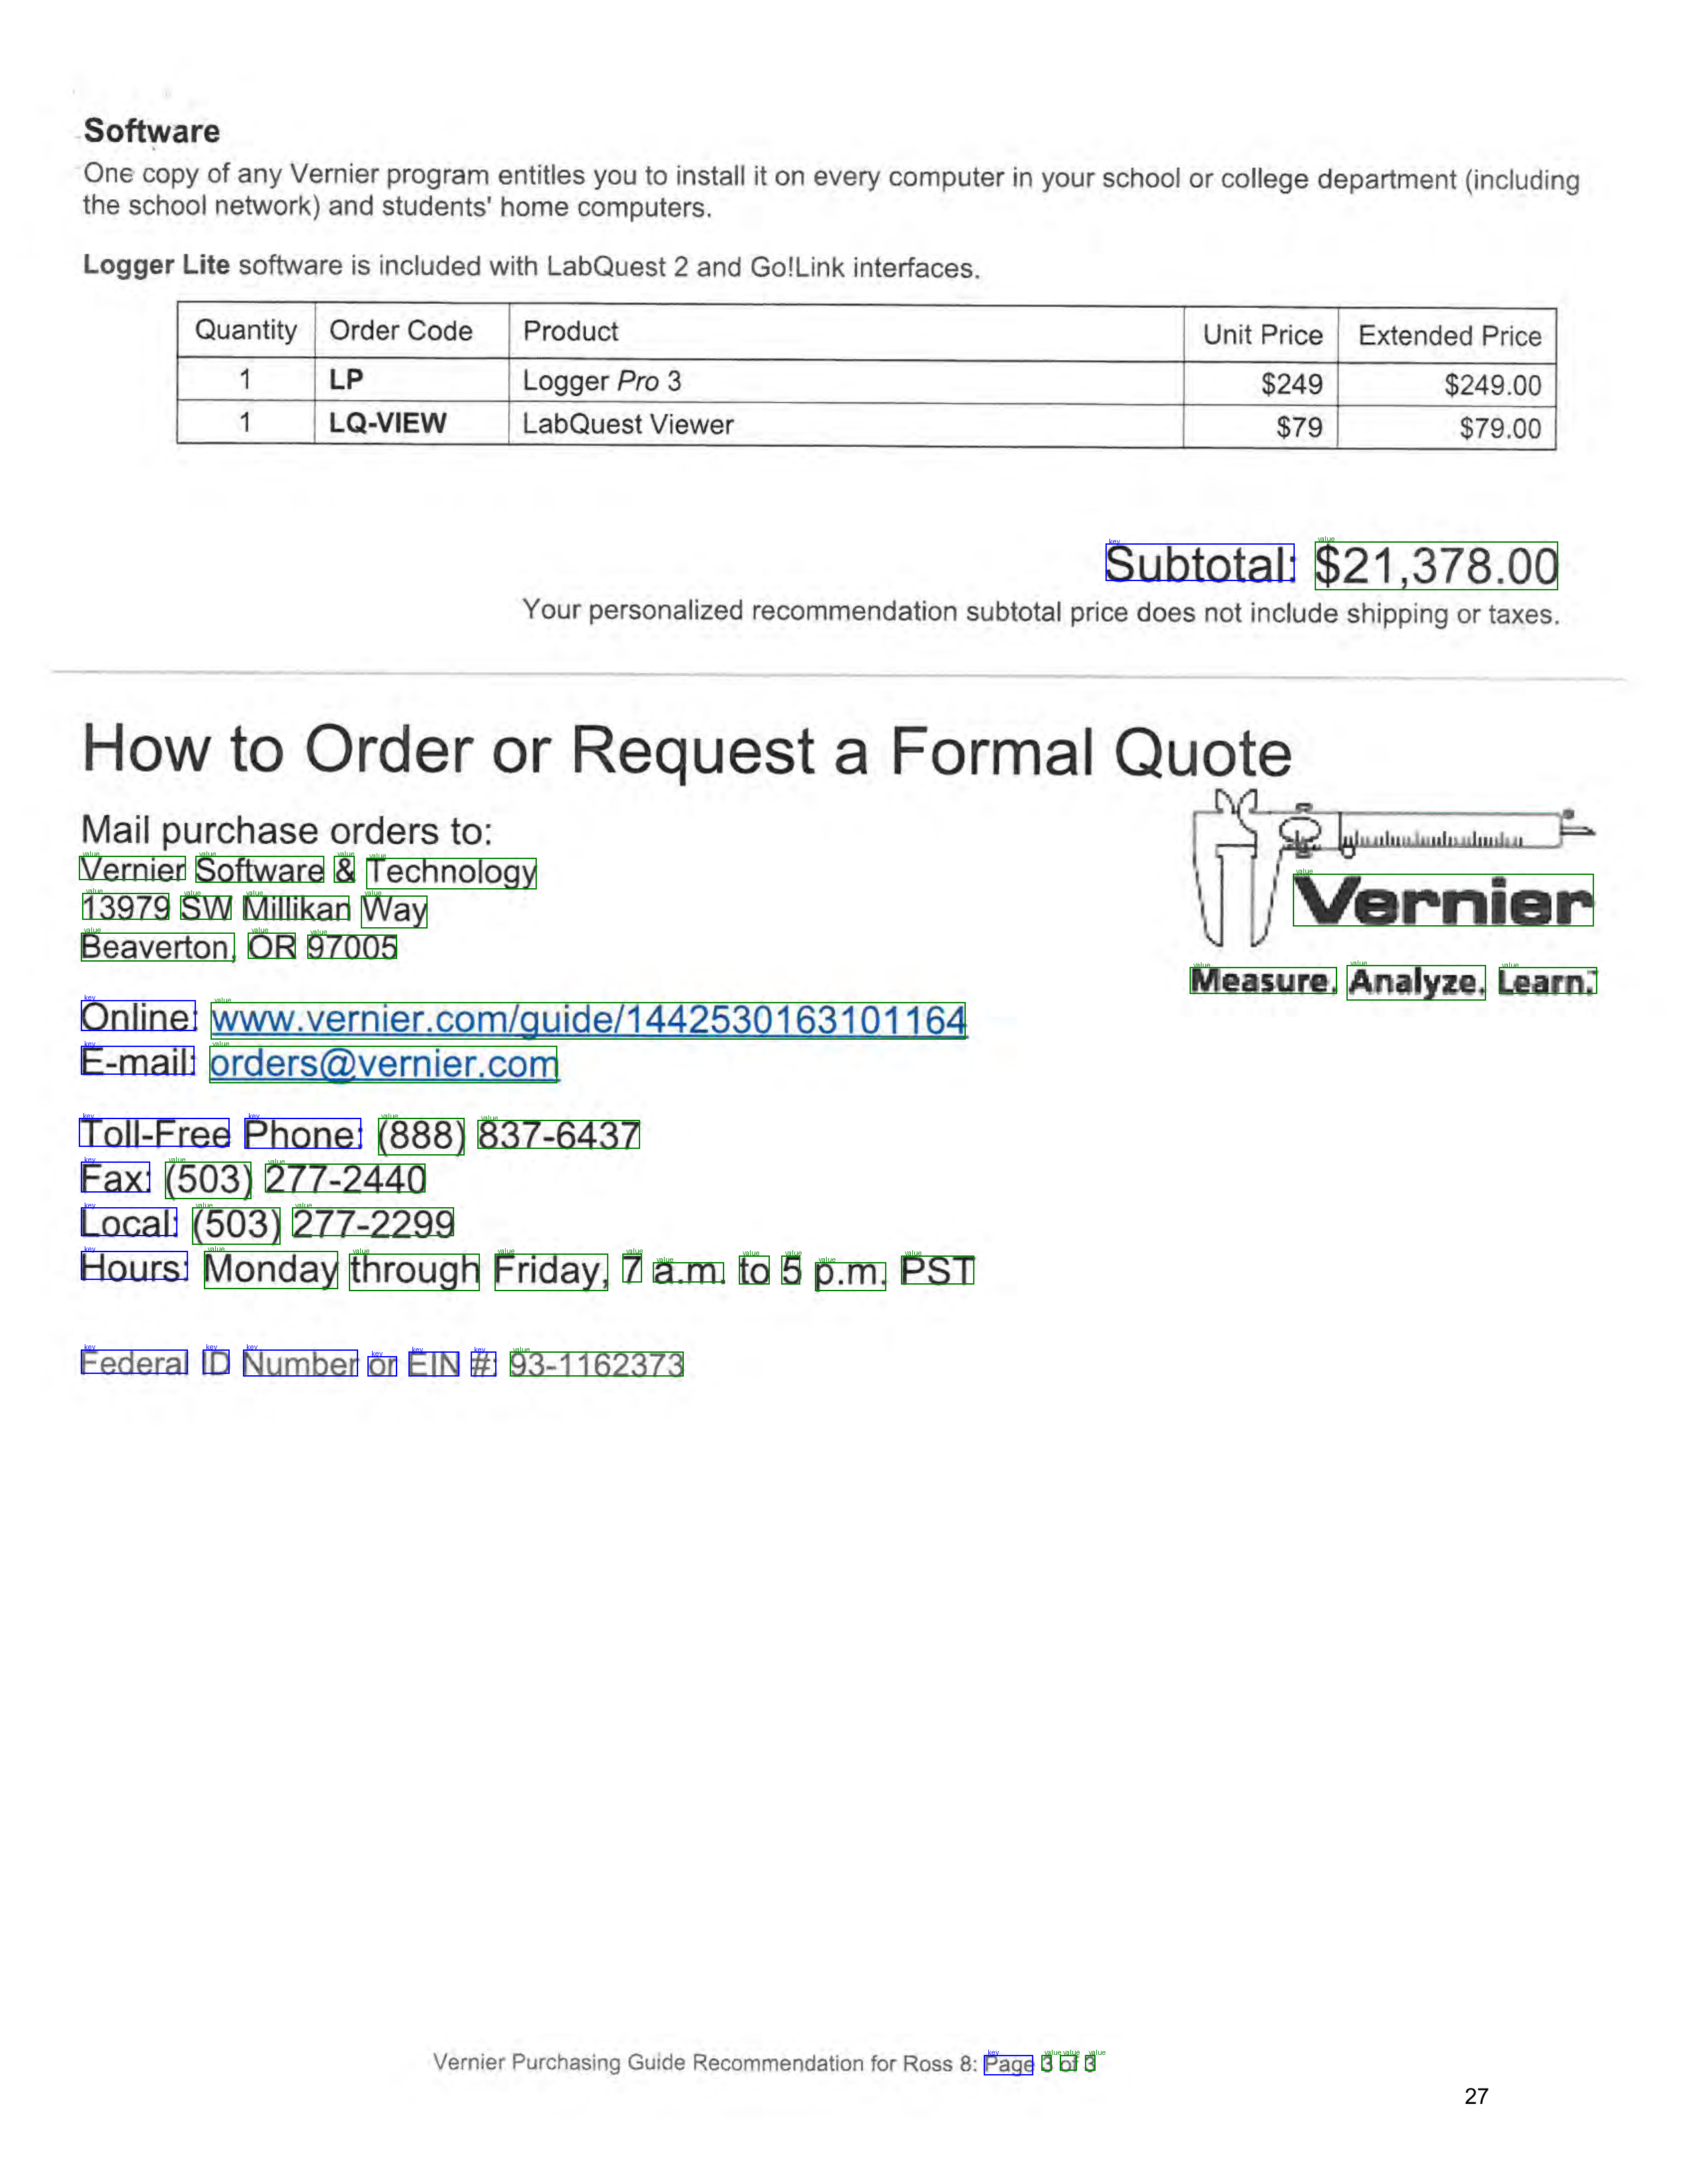

✅ Ground Truth:


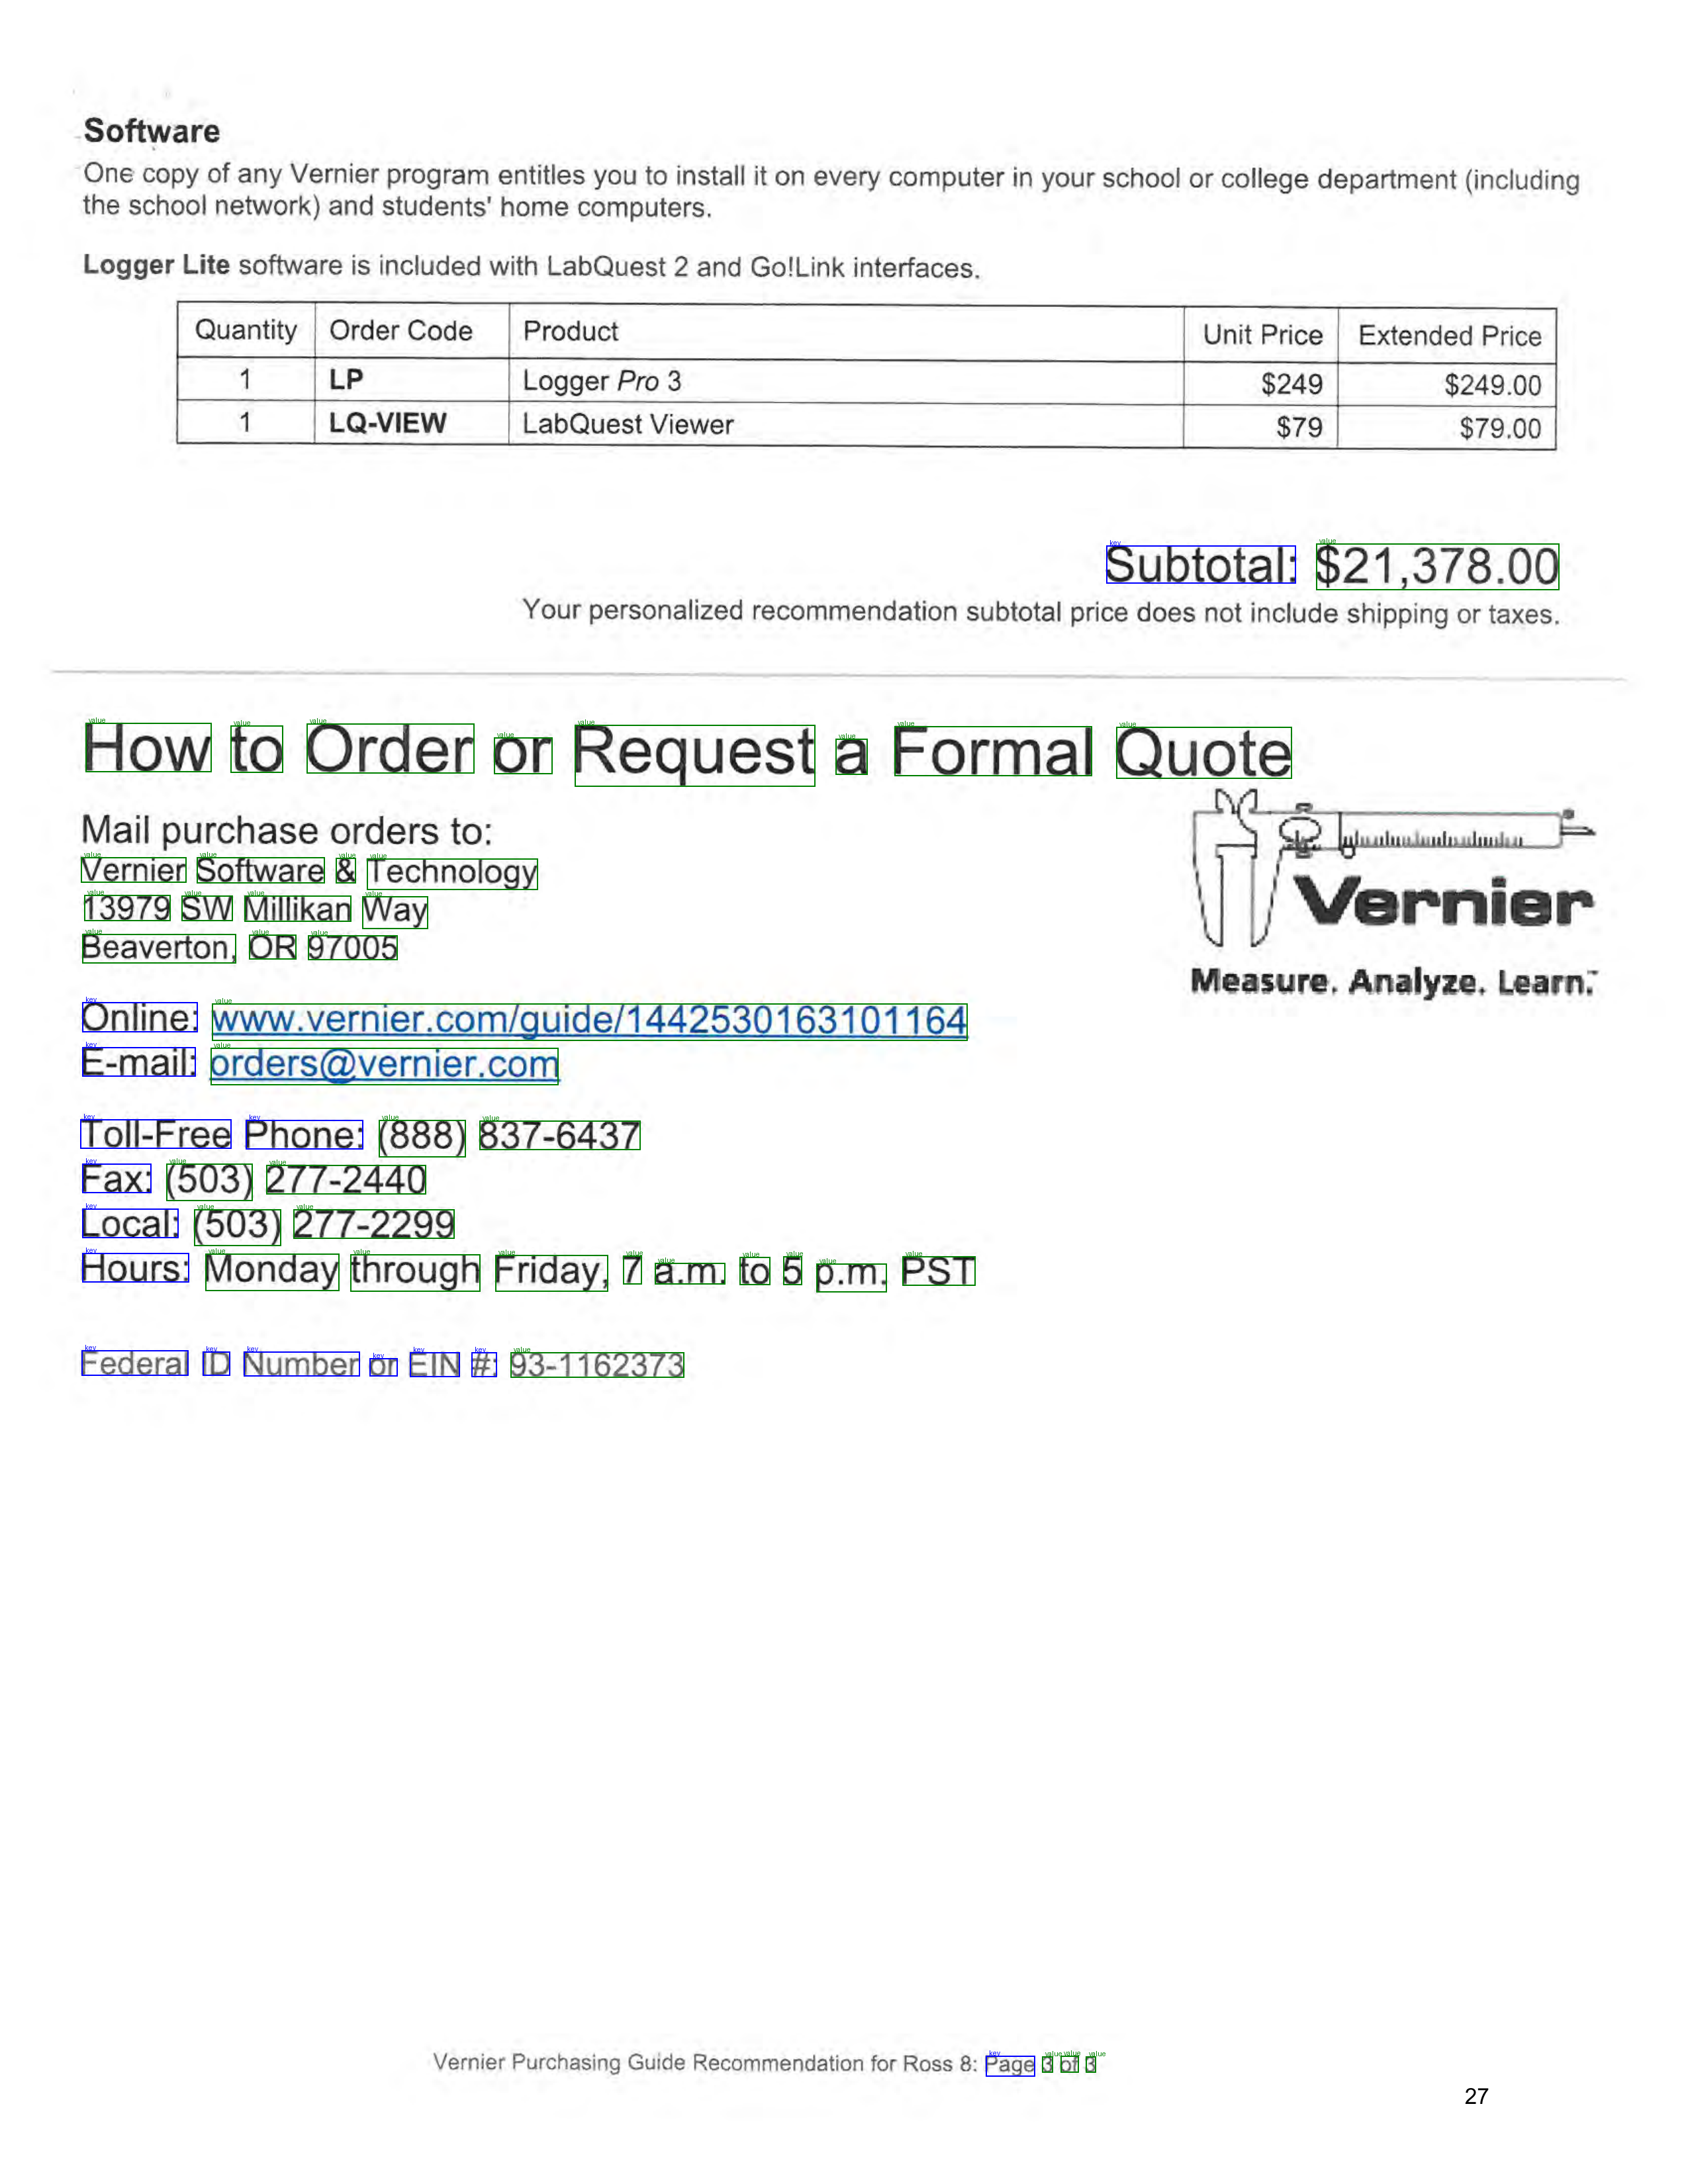

In [14]:
#predict_and_visualize("aaf643426f0250efd10de3d9df63b407292f3fcc2aa335e399c37aca32443ea1")
#predict_and_visualize("aaed61e79aa3edbae844f5775789ebb6aa1a94a23d9cb3468d2cfc974af304e5")
#predict_and_visualize("aa35720ba3611f946c372cc99d8cd1d78e81265b8ceb51dcdb4672d196944c2b")
#predict_and_visualize("aa7c58830d0e84f98e9fdec1bc9e131227f9b00106aa3c78bc8ea346cfb9eac0")
#predict_and_visualize("faa5d71172e2e9959b41a5aec4fd2ab700534d1b2729484d2d5f26472cd56cfa")
#predict_and_visualize("ffe462e43b9dff12e78ea8fb69332abfb789da171a8597f5bb961853e06e6fa2")
#predict_and_visualize("feb2c4b21388318c7a51cc0aaf0e7c673a07f5204a40549a281bef065bb77925")
#predict_and_visualize("feaf84d435bd46100db82de51f5a989ff4d39fdcdb040a7044720b943e34b7d7")
#predict_and_visualize("df6b0a4cf1908bb95be874e4efa59411c685095d7bb596879961563503b5c239")


_______